# MLP Neural Net (Classification Task) Notebook
This python notebook is used to demonstrate a Multi-Layer  perceptron neural Net architecture
for classification task of the  [soured from UCI](https://archive.ics.uci.edu/dataset/45/heart+disease)

A replica of this functionality is also ported to C# .Net 

### Imports

In [41]:
import pandas as pd
import numpy as np
import math
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils.vis_utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from typing import Dict, Tuple, List, Any, Optional
import sys
import enum
from tqdm.notebook import trange, tqdm
from tqdm.notebook import tqdm_notebook
from collections import namedtuple
%matplotlib inline

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

### Global constants

In [111]:
DATA_FILE_PATH = "../data/heart_disease_dataset.csv"
problem_details = namedtuple(
    "problem_details",["problem_title", "label_index", "label_name" ]
)
PROBLEM_DETAILS = problem_details("Heart Disease Classification Problem", -1, "target")
FILE_DELIMITER = ","
TRAIN_VALID_SPLIT_FRACTION = 0.80
VALID_SPLIT_FRACTION = 0.20
TEST_SPLIT_FRACTION = 1.0 - TRAIN_VALID_SPLIT_FRACTION
IS_SHUFFLE_DATA = True
NEURAL_NET_TOPOLOGY_FILENAME = "../resources/classification_neural_net.png"
RANDOM_SEED = 0
EPOCH_REPORT_LIMIT = 20
DROPOUT_RATE = 0.2

np.random.seed(0)

### Enumerations
 - Task type enums

In [3]:
class TaskType(enum.Enum):
    regression = 1
    classification = 2

### Get the ML task dataset
 - Read the dataset from the store (csv file)
 - Move the response column to the end of the dataframe
 - Extract feature dataset (X) and response/labels (y)

In [12]:
data_df = pd.read_csv(DATA_FILE_PATH, sep=FILE_DELIMITER)
new_data_df = data_df.copy()
response_df = new_data_df.pop(PROBLEM_DETAILS.label_name)
new_data_df[PROBLEM_DETAILS.label_name] = response_df.values
X = new_data_df.values[:, :-1]
y = new_data_df.values[:, -1].reshape(-1,1)

In [13]:
new_data_df.head()

,age,trestbps,chol,thalach,oldpeak,slope,sex_0,sex_1,cp_0,cp_1,...,ca_0,ca_1,ca_2,ca_3,thal_0.0,thal_1.0,thal_2.0,thal_3.0,thal_4.0,target
0,63,145,233,150,2.3,3,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,67,160,286,108,1.5,2,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1
2,67,120,229,129,2.6,2,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,37,130,250,187,3.5,3,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,41,130,204,172,1.4,1,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [14]:
new_data_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,303.0,54.594059,9.016370,29.0,48.0,56.0,61.0,77.0
trestbps,303.0,131.785479,17.748338,94.0,120.0,130.0,140.0,200.0
chol,303.0,246.547855,52.175933,126.0,211.0,241.0,275.0,564.0
thalach,303.0,149.194719,23.173368,71.0,132.0,152.0,165.5,202.0
oldpeak,303.0,1.057756,1.165025,0.0,0.0,0.8,1.6,6.2
slope,303.0,1.590759,0.617767,1.0,1.0,2.0,2.0,3.0
sex_0,303.0,0.323432,0.468560,0.0,0.0,0.0,1.0,1.0
sex_1,303.0,0.676568,0.468560,0.0,0.0,1.0,1.0,1.0
cp_0,303.0,0.013201,0.114325,0.0,0.0,0.0,0.0,1.0
cp_1,303.0,0.079208,0.270510,0.0,0.0,0.0,0.0,1.0


In [15]:
X[:5]

array([[ 63. , 145. , 233. , 150. ,   2.3,   3. ,   0. ,   1. ,   0. ,
          1. ,   0. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ,   1. ,
          1. ,   0. ,   1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   1. ,
          0. ,   0. ],
       [ 67. , 160. , 286. , 108. ,   1.5,   2. ,   0. ,   1. ,   0. ,
          0. ,   0. ,   0. ,   1. ,   1. ,   0. ,   0. ,   0. ,   1. ,
          0. ,   1. ,   0. ,   0. ,   0. ,   1. ,   0. ,   0. ,   0. ,
          1. ,   0. ],
       [ 67. , 120. , 229. , 129. ,   2.6,   2. ,   0. ,   1. ,   0. ,
          0. ,   0. ,   0. ,   1. ,   1. ,   0. ,   0. ,   0. ,   1. ,
          0. ,   1. ,   0. ,   0. ,   1. ,   0. ,   0. ,   0. ,   0. ,
          0. ,   1. ],
       [ 37. , 130. , 250. , 187. ,   3.5,   3. ,   0. ,   1. ,   0. ,
          0. ,   0. ,   1. ,   0. ,   1. ,   0. ,   1. ,   0. ,   0. ,
          1. ,   0. ,   1. ,   0. ,   0. ,   0. ,   0. ,   0. ,   0. ,
          1. ,   0. ],
       [ 41. , 130. , 204. , 172. ,   1.4,   1. ,   1. ,

In [16]:
y[:5]

array([[0.],
       [1.],
       [0.],
       [0.],
       [0.]])

In [21]:
print(f"NUmber of label classes are: {len(np.unique(y))}")

NUmber of label classes are: 2


### Preprocess dataset
 - Split data into train, validation and test datasets


In [99]:
def splitDataset(
    X: np.ndarray, 
    y: np.ndarray,    
    is_shuffle: bool = IS_SHUFFLE_DATA
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    n_all_rows = X.shape[0]
    X_train_valid, X_test, y_train_valid, y_test = train_test_split(
        X, 
        y, 
        train_size=TRAIN_VALID_SPLIT_FRACTION, 
        shuffle=is_shuffle,
        random_state=0
    )
    print(f"n_all_rows: {n_all_rows}\tn_train_valid_rows: {X_train_valid.shape[0]}\tTRAIN_VALID_SPLIT_FRACTION: {TRAIN_VALID_SPLIT_FRACTION}\n")
    return (X_train_valid, X_test, y_train_valid, y_test)

def splitDataset2(
    dataset: pd.DataFrame,   
    is_shuffle: bool = IS_SHUFFLE_DATA
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    test_dataframe_df = dataset.sample(frac=TEST_SPLIT_FRACTION, random_state=RANDOM_SEED)
    train_dataframe_df = dataset.drop(test_dataframe_df.index)
    X_train_valid = train_dataframe_df.values[:, :-1]
    X_test = test_dataframe_df.values[:, :-1]
    y_train_valid = train_dataframe_df.values[:, -1].reshape(-1,1)
    y_test = test_dataframe_df.values[:, -1].reshape(-1,1)
    return (X_train_valid, X_test, y_train_valid, y_test)

X_train_valid, X_test, y_train_valid, y_test = splitDataset2(new_data_df)
#X_train_valid, X_test, y_train_valid, y_test = splitDataset(X, y)
print(f"X_train_valid:\n{X_train_valid[:5]}\nX_test:\n{X_test[:5]}\n")
print(f"y_train_valid:\n{y_train_valid[:5]}\ny_train_valid:\n{y_test[:5]}\n")
print("\n\n")


X_train_valid:
[[ 63.  145.  233.  150.    2.3   3.    0.    1.    0.    1.    0.    0.
    0.    0.    1.    0.    0.    1.    1.    0.    1.    0.    0.    0.
    0.    0.    1.    0.    0. ]
 [ 67.  160.  286.  108.    1.5   2.    0.    1.    0.    0.    0.    0.
    1.    1.    0.    0.    0.    1.    0.    1.    0.    0.    0.    1.
    0.    0.    0.    1.    0. ]
 [ 67.  120.  229.  129.    2.6   2.    0.    1.    0.    0.    0.    0.
    1.    1.    0.    0.    0.    1.    0.    1.    0.    0.    1.    0.
    0.    0.    0.    0.    1. ]
 [ 37.  130.  250.  187.    3.5   3.    0.    1.    0.    0.    0.    1.
    0.    1.    0.    1.    0.    0.    1.    0.    1.    0.    0.    0.
    0.    0.    0.    1.    0. ]
 [ 41.  130.  204.  172.    1.4   1.    1.    0.    0.    0.    1.    0.
    0.    1.    0.    0.    0.    1.    1.    0.    1.    0.    0.    0.
    0.    0.    0.    1.    0. ]]
X_test:
[[ 58.  130.  197.  131.    0.6   2.    1.    0.    0.    0.    0.    0.
    1.  

### MLP Neural Net
 - Callback class for the MLP Neural Net
 - Class encpasulating the functionality of a MLP neural net

In [100]:
class PerformancePrintingCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        
            if (int(epoch) % EPOCH_REPORT_LIMIT) == 0:
                print(
                    f"Epoch: {epoch:>3}"
                    + f" | Loss: {logs['loss']:.4f}"
                    + f" | Accuracy: {logs['accuracy']:.4f}"
                    + f" | Loss (Validation) loss: {logs['val_loss']:.4f}"
                    + f" | Accuracy (validation): {logs['val_accuracy']:.4f}"
                )
                
    

In [112]:
class MLPClassificationNeuralNet:
    def __init__(
        self,
        X: np.array,
        y: np.array,
        network_topology: Dict[str, Any],
        network_params: Dict[str, Any],
        task_type: TaskType = TaskType.regression
    ):
        """
        Constructor
        """
        print("Constructing the MLP neural network ..")
        self._X_train_valid, self._X_test, self._y_train_valid, self._y_test = splitDataset(X, y)
        self._n_features = self._X_train_valid.shape[1]
        self._n_nodes_per_hidden_layer = network_topology["n_nodes_per_hidden_layer"]
        self._n_layers = len(self._n_nodes_per_hidden_layer)        
        self._optimizer_type = network_params["optimizer_type"]
        self._hidden_activation_function = network_params["hidden_activation_function"]
        self._batch_size = network_params["batch_size"]
        self._n_epochs = network_params["n_epochs"]
        self._validation_split = network_params["validation_split"]
        self._loss_function = network_params["loss_function"]
        self._performance_function = network_params["performance_metric"]
        self._task_type = task_type
        self._early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        self._normalizer = self.createNormalizer()
                
        self._model = None
        self._history = None
        self._train_accuracy = None
        self._valid_accuracy = None
        self._train_loss = None
        self._valid_loss = None
        self._test_results = dict()        

    def createNormalizer(self) -> Any:
        """
        Create the data normalizer
        """
        normalizer = tf.keras.layers.Normalization(input_dim=self._n_features, axis=-1)
        normalizer.adapt(self._X_train_valid)
        return normalizer

    def testNormalizer(self):
        denormalized_values = self._X_train_valid[:10]
        normalized_values = self._normalizer(denormalized_values).numpy()        
        print(f"denormalized_values:\n{denormalized_values}\n\n\n")
        print(f"normalized_values:\n{normalized_values}\n")
      
    def _createMultipleHiddenLayerNN(self):
        """
        Creates a multiple hidden layer NN topology
        """
        self._model = tf.keras.Sequential()
        self._model.add(self._normalizer)
        self._model.add(tf.keras.layers.Dense(
            units=self._n_nodes_per_hidden_layer[0],
            # input_shape=(self._n_features,), 
            activation=self._hidden_activation_function)
        )
        self._model.add(tf.keras.layers.Dropout(DROPOUT_RATE))
        if len(self._n_nodes_per_hidden_layer) > 1:
            for n_hidden_nodes in self._n_nodes_per_hidden_layer[1:]:
                self._model.add(tf.keras.layers.Dense(n_hidden_nodes, activation=self._hidden_activation_function))
                self._model.add(tf.keras.layers.Dropout(DROPOUT_RATE))
        self._model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
        self._model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss ='binary_crossentropy', 
            metrics=['accuracy'])
        return self._model

    def createNeuralNetModel(self):
        """
        Creates the Multi-Layer Perceptron Neural Net
        """
        print("Creating the neural network..")
        self._model = self._createMultipleHiddenLayerNN()
        self.visualizeNeuralNetwork()
    
    def trainClassificationModel(self):
        """
        Computes the training cycle for regression problem using a neural network model
        """
        self._history = self._model.fit(
            self._X_train_valid,
            self._y_train_valid,
            epochs=self._n_epochs, 
            batch_size=self._batch_size,
            verbose=0,
            validation_split=self._validation_split,
            callbacks=[PerformancePrintingCallback()]
            )
        self._train_accuracy = self._model.history.history["accuracy"]
        self._valid_accuracy = self._model.history.history["val_accuracy"]
        self._train_loss = self._model.history.history["loss"]
        self._valid_loss = self._model.history.history["val_loss"]
        return {
            "accuracy": self._train_accuracy,
            "val_accuracy": self._valid_accuracy,
            "loss": self._train_loss,
            "val_loss": self._valid_loss
        }
    def toBinary(self, preds: np.array):
        """
        Converts class probabilities to binary classes
        :return: Returns binary class array 
        """
        result = []
        for p in preds:
            if p[0] >= 0.5:
                klass=1
            else:
                klass=0
            result.append(klass)
        ressult_array = np.array(result).reshape(-1,1)
        return ressult_array

    def predict(
            self, 
            X_hat: np.array
        ) -> Tuple[np.array, np.array]:
        """
        Predict the call price using the model
        :param X_hat: Input features
        :return: Returns the predicted class and probablities
        """
        y_prob = self._model.predict(X_hat, batch_size=self._batch_size)
        y_hat = self.toBinary(y_prob)
        return (y_hat, y_prob)

    def evaluate(self) -> Dict[str, float]:
        """
        Evaluate the MLP model
        """
        self._test_results['mlp_model'] = self._model.evaluate(self._X_test, self._y_test, verbose=0)
        test_result_df = pd.DataFrame(self._test_results, index=[f'Binanry Cross Entropy {[PROBLEM_DETAILS.label_name]}', 'Accuracy']).T
        return test_result_df

    def visualizeModelLossAndAccuracy(self):
        plt.figure(figsize=(14,5))
        plt.subplot(1,2,1)
        plt.plot(self._model.history.history['loss'], label='loss')
        plt.plot(self._model.history.history['val_loss'], label='val_loss')      
        plt.xlabel('Epoch')
        plt.ylabel('Mean Absolute Error')
        plt.title("MAE Performance metric")
        plt.legend()
        plt.grid(True)
    
        plt.subplot(1,2,2)
        plt.plot(self._model.history.history['accuracy'], label='Accuracy')
        plt.plot(self._model.history.history['val_accuracy'], label='val_Accuracy')
        plt.ylim([0, 2])
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title("Accuracy Performance metric")
        plt.legend()
        plt.grid(True)
      
    def visualizeNeuralNetwork(self):
        """
        Method is used to visualize the created neural network structure/topology
        """
        print("Neural Network topology:\n\n")
        self._model.summary()
        plot_model(
            self._model, 
            to_file=NEURAL_NET_TOPOLOGY_FILENAME, 
            show_shapes=True, show_layer_names=True
        )
        print(f"\nThe detailed Neural Network topology has been generated and can be found here: '{NEURAL_NET_TOPOLOGY_FILENAME}'")

    def reportConfusionMatrix(
        self
    ):
        """
        Reports the confusion matrix
        """
        plot_title = PROBLEM_DETAILS.problem_title        
        y_pred, y_prob = self.predict(self._X_test)
        y_true = self._y_test
        con_matrix = confusion_matrix(y_true, y_pred)
        print(f"\nconfusion_matrix:\n{con_matrix}\n")
        

        
    

### Neural Network configurations

In [113]:
neural_network_topology = {
    #"n_nodes_per_hidden_layer": [10], 
    "n_nodes_per_hidden_layer": [64, 64],       
}

neural_network_params = {
    "optimizer_type": "adam",
    "hidden_activation_function": "relu",    
    "batch_size": 128,
    "n_epochs": 200,
    "validation_split": VALID_SPLIT_FRACTION,
    "loss_function": "mae",
    "performance_metric": "accuracy"    
}


### Run "regression" task MLP neural net prediction problem 


Run of the Neural Net classification task
X.shape: (303, 29)	y.shape: (303, 1)
Constructing the MLP neural network ..
n_all_rows: 303	n_train_valid_rows: 242	TRAIN_VALID_SPLIT_FRACTION: 0.8

Creating the neural network..
Neural Network topology:


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_18 (Normaliza  (None, 29)               59        
 tion)                                                           
                                                                 
 dense_54 (Dense)            (None, 64)                1920      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_55 (Dense)            (None, 64)                4160      
                                                                 
 d

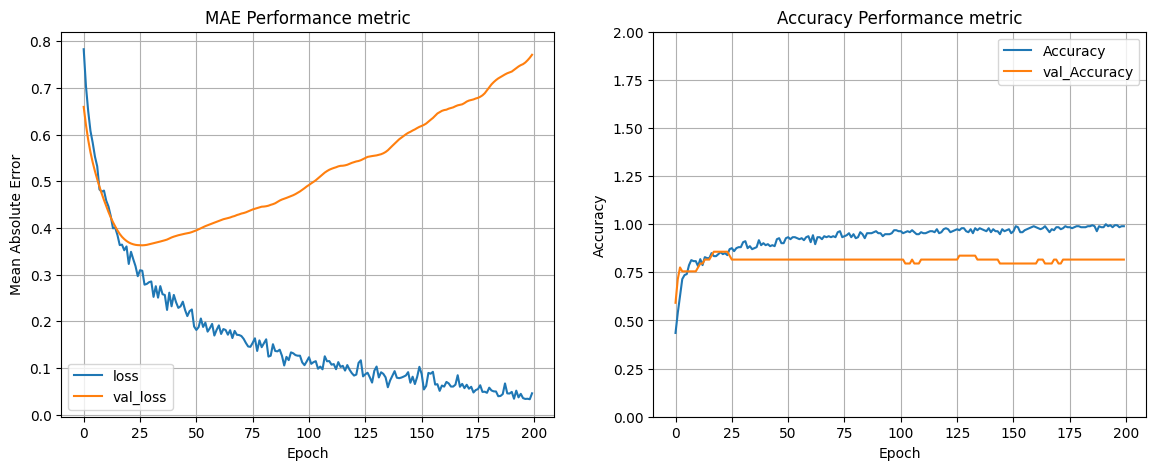

In [114]:
def runMLPNeuralNetClassificationTask():
    """
    Runs the Neural Net regression task
    """
    print(f"\nRun of the Neural Net classification task")
    print(f"X.shape: {X.shape}\ty.shape: {y.shape}")
    nn_model = MLPClassificationNeuralNet(
        X=X,
        y=y,
        network_topology=neural_network_topology,
        network_params=neural_network_params,
        task_type=TaskType.classification
    )
    nn_model.createNeuralNetModel()
    train_metrics = nn_model.trainClassificationModel()
    valid_accuracy = np.round(train_metrics["val_accuracy"][-1], 4)
    valid_cross_entropy = np.round(train_metrics["val_loss"][-1], 4)
    print(f"NN Training metrics:")
    print(f"Validated Accuracy: {valid_accuracy}")
    print(f"Validated Binary Cross Entropy loss: {valid_cross_entropy}")
    print("\n\n")
    nn_model.visualizeModelLossAndAccuracy()
    nn_model.reportConfusionMatrix()
    test_result_df = nn_model.evaluate()
    print(f"\n\nPerformance summary results are:\n\n{test_result_df}\n")
    # nn_model.testNormalizer()
   
    

runMLPNeuralNetClassificationTask()